In [30]:
%load_ext autoreload
%autoreload 2
%autosave 30

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import matplotlib.pyplot as plt
from plotutils import plot_images_as_grid

from imageprosessing import hist_match_images, enhance_motion_contrast, normalize_data
from sharedvariables import get_video_sessions
from video_session import VideoSession
from imageprosessing import SessionPreprocessor
from classificationutils import SessionClassifier
from patchextraction import SessionPatchExtractor, NegativeExtractionMode
from patchextraction import SessionPatchExtractor as PE
from cnnlearning import CNN

from learningutils import ImageDataset
from classificationutils import create_probability_map
from plotutils import *
from cnnlearning import TrainingTracker, train
import os
import collections
import pathlib

import scipy
import skimage
from skimage.morphology import binary_dilation as bd
import re
import numpy as np
import pandas as pd
import torch
import cv2
import copy

from tqdm.contrib import tzip

from patchextraction import extract_patches
from patchextraction import SessionPatchExtractor as PE
from imageprosessing import ImageRegistrator
from collections import OrderedDict

# change this
result_folder_name = 'uid0-sc-npp32-tp3-ps23-mt0-par'

## ## ## ## ##
def get_number_from_string(string):
    return int(re.findall(r'\d+', string)[0])

print()
print('Training configuration')
print('----------------------')
print('Folder name:', result_folder_name)
mc_sc_str = result_folder_name.split('-')[1]
assert 'mc' in mc_sc_str or  'sc' in mc_sc_str

for string in result_folder_name.split('-'):
    if 'mc' in string or 'sc' in string:
        drop_confocal = False
        if 'mc' in string:
            translation_pixels = get_number_from_string(string)

            n_chanels = get_number_from_string('mc_sc_str')
            mixed_channels = True
            if n_chanels == 2:
                drop_confocal = True
            print('Mixed channel')
            print('Number of channels', n_chanels)
            print('Dropping confocal?', drop_confocal )
        else:
            mixed_channels = False
            print('Single Channel')

for string in result_folder_name.split('-'):
    if 'ps' in string:
        patch_size = get_number_from_string(string)
        print('Patch size:', patch_size)
 
for string in result_folder_name.split('-'):
    if 'tp' in string:
        translation_pixels = get_number_from_string(string)
        print('Translation pixels:', translation_pixels)

if 'pr' in result_folder_name:
    do_preprocessing = True
else:
    do_preprocessing = False
print('Do preprocessing:', do_preprocessing)

if 'rect' in result_folder_name:
    negative_extraction_mode = NegativeExtractionMode.RECTANGLE
elif 'circ' in result_folder_name:
    negative_extraction_mode = NegativeExtractionMode.CIRCLE
elif 'perp' in result_folder_name:
    negative_extraction_mode = NegativeExtractionMode.PERPENDICULAR
elif 'par' in result_folder_name:
    negative_extraction_mode = NegativeExtractionMode.PARALLEL
print('Negative extraction mode:', negative_extraction_mode)

classifier_params = collections.OrderedDict(        
    patch_size=patch_size,
    
    mixed_channels=mixed_channels,
    drop_confocal=drop_confocal,

    n_negatives_per_positive=32,
    negative_extraction_mode=NegativeExtractionMode.CIRCLE,                             
    use_vessel_mask=True
)


report_images_folder = os.path.join(
    '..', '..', 'thesis-report', 'images', result_folder_name,
)
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

result_evaluation_folder = f'tmp-res/{result_folder_name}/evaluation'
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

print('-----------------------')
results = TrainingTracker.from_file(os.path.join('tmp-res', result_folder_name, 'results.pkl'))
print('Training results loaded')

recorded_models_props = results.recorded_models['best_valid_balanced_accuracy']
model =  recorded_models_props['model'].eval()
print('Model validation performance\n',  recorded_models_props['valid_classification_results'])
print()

video_sessions = get_video_sessions(marked=True, registered=False, validation=True)
print('loaded validation Video sessions:', len(video_sessions))
[vs.basename for vs in video_sessions]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 30 seconds

Training configuration
----------------------
Folder name: uid0-sc-npp32-tp3-ps23-mt0-par
Single Channel
Patch size: 23
Translation pixels: 3
Do preprocessing: False
Negative extraction mode: NegativeExtractionMode.PARALLEL
-----------------------
Training results loaded
Model validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0            0.89045  0.894491     0.881331     0.899568

loaded validation Video sessions: 3


['Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped',
 'Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped',
 'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped']

# Performance on validation data

### Load validation videos and make sure vessel masks are ok

In [26]:
validation_video_sessions = get_video_sessions(marked=True, validation=True)

[vs.load_vessel_masks(False) for vs in validation_video_sessions]
[vs.basename for vs in validation_video_sessions]

['Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped',
 'Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped',
 'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped']

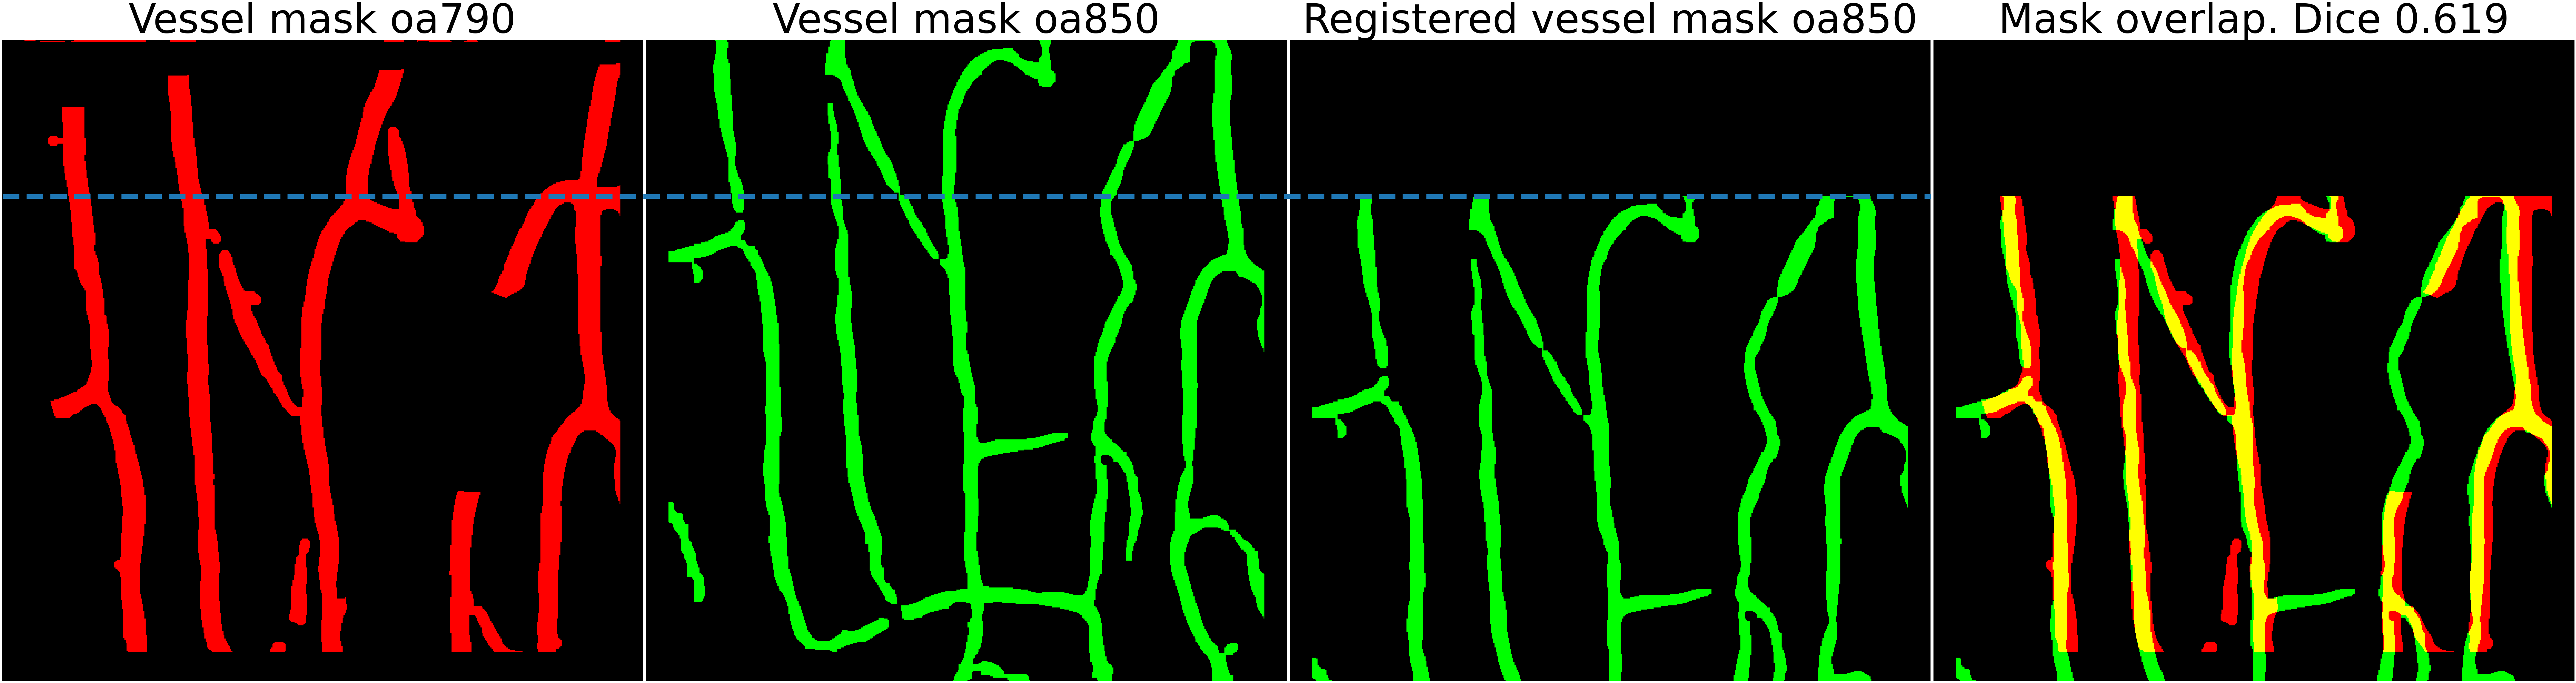

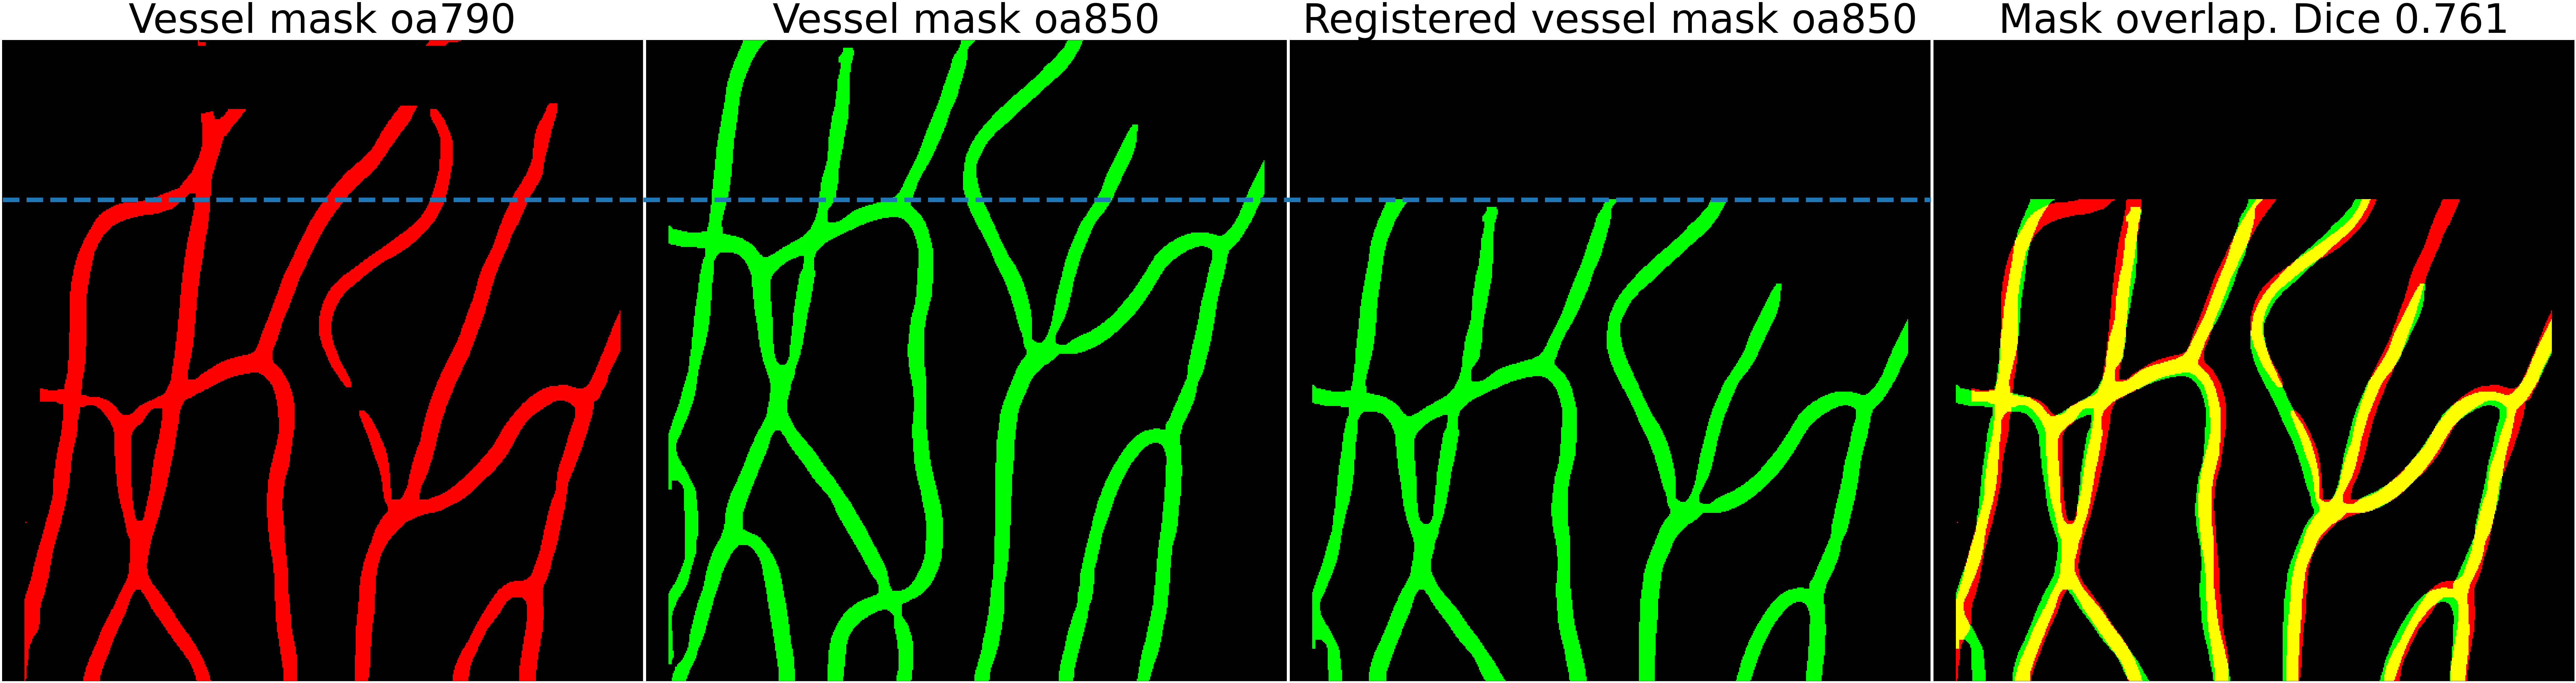

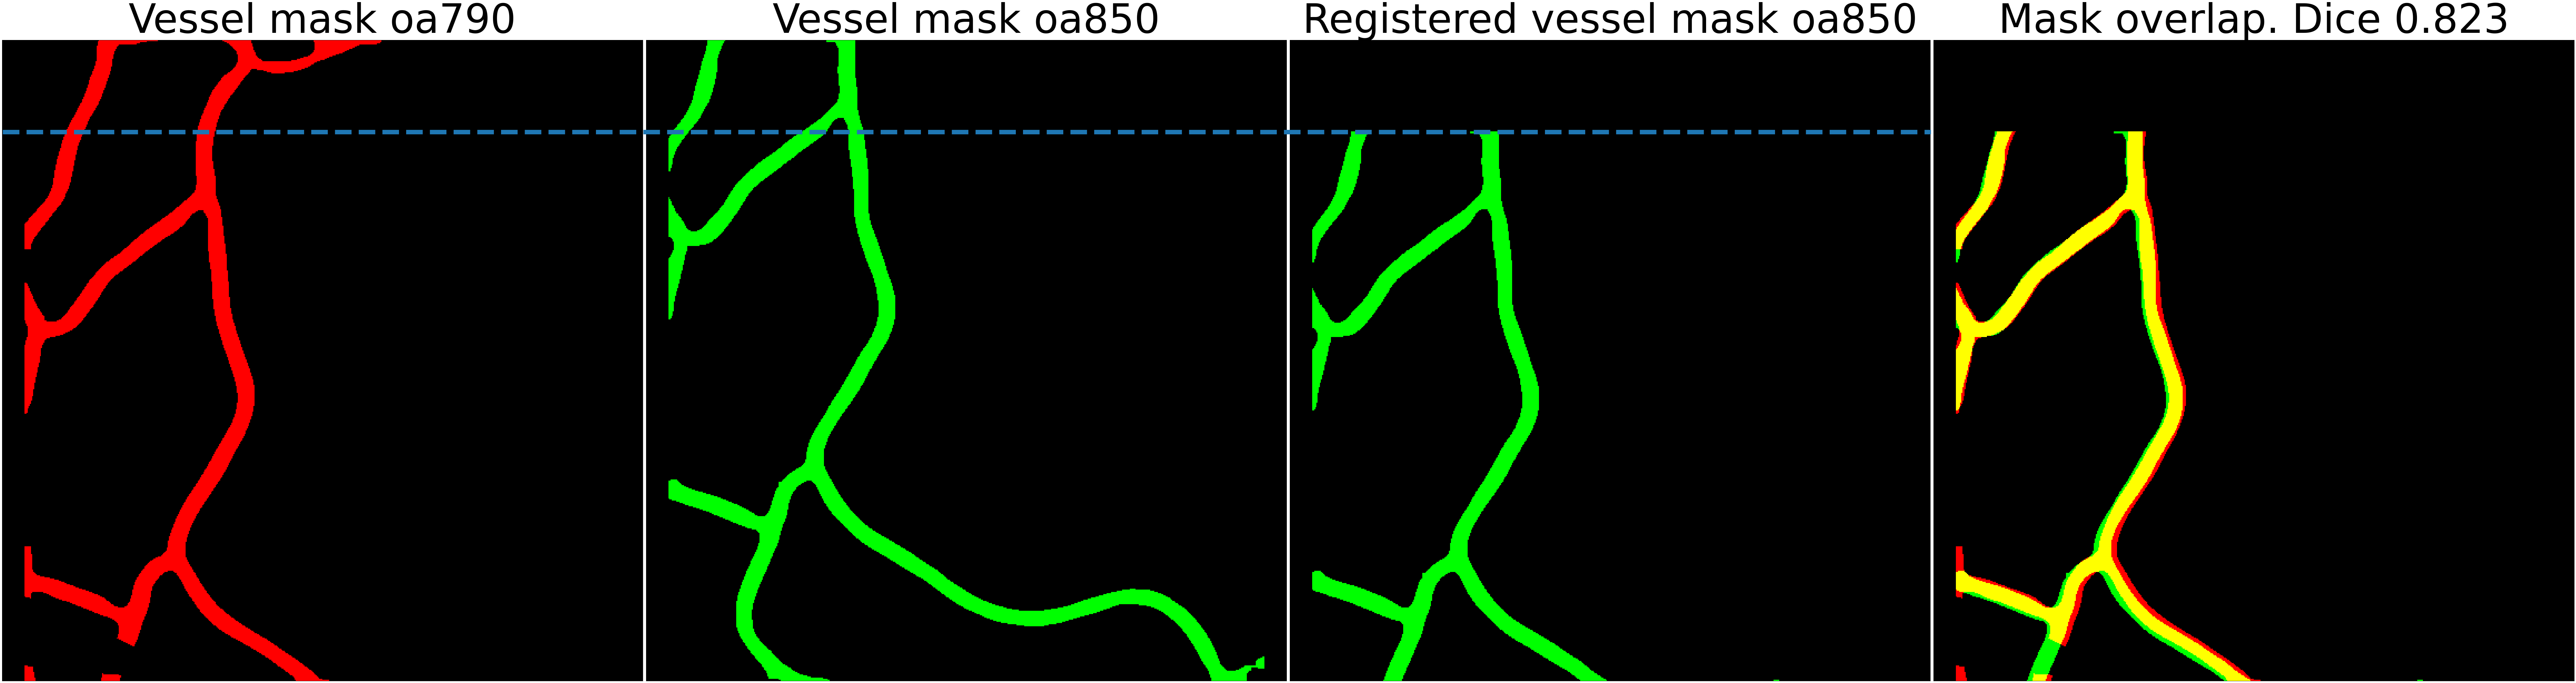

In [27]:
for vs in validation_video_sessions:
    vs.visualize_registration()

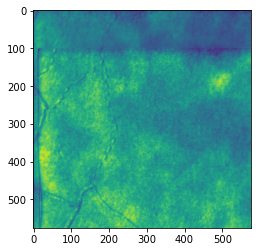

In [28]:
from imageprosessing import equalize_adapt_hist_stack, enhance_motion_contrast_de_castro, normalize_data
# Apply preprocessing if needed
if do_preprocessing:
    for vs in validation_video_sessions:
        vsp = SessionPreprocessor(vs, preprocess_functions=[
            equalize_adapt_hist_stack, 
            lambda frames: enhance_motion_contrast_de_castro(frames, sigma=.5),
            lambda frames: normalize_data(frames, (0, 255)).astype(np.uint8)
        ])
        vsp.apply_preprocessing_to_oa790()
plt.imshow(vs.frames_oa790[0])

### Performance on patch classification

In [31]:
valid_recorded_model_props = results.recorded_models['best_valid_balanced_accuracy']
model = valid_recorded_model_props['model'].eval()

classification_results = valid_recorded_model_props['valid_classification_results']

sensitivities = []
specificities = []
balanced_accuracies  = []
accuracies = []

print('General validation performance\n', classification_results)
for vs in validation_video_sessions:
    vs_c = SessionClassifier(vs, model, **classifier_params)
    classification_results = vs_c.classify_cells()
    
    sensitivity = classification_results.positive_accuracy
    specificity = classification_results.negative_accuracy
    balanced_accuracy = classification_results.balanced_accuracy
    accuracy = classification_results.accuracy
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    balanced_accuracies.append(balanced_accuracy)
    accuracies.append(accuracy)
    
    print(vs.basename)
    print(f'Sensitivity: {sensitivity:.3f}', 
          f'Specificity: {specificity:.3f}',
          f'Balanced acc: {balanced_accuracy:.3f}',
          f'accuracy: {accuracy:.3f}', sep='\n')
    print('-----------')

General validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0            0.89045  0.894491     0.881331     0.899568
Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped
Sensitivity: 0.779
Specificity: 0.493
Balanced acc: 0.636
accuracy: 0.512
-----------
Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped
Sensitivity: 0.669
Specificity: 0.627
Balanced acc: 0.648
accuracy: 0.631
-----------
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Sensitivity: 0.997
Specificity: 0.013
Balanced acc: 0.505
accuracy: 0.071
-----------


In [6]:
test_sensitivity = np.mean(sensitivities)
test_specificity = np.mean(specificities)
test_balanced_accuracy = np.mean(balanced_accuracies)
test_accuracy = np.mean(accuracies)

performance_data = {
    'Balanced accuracy': test_balanced_accuracy,
    'Accuracy': test_accuracy,
    'Sensitivity': test_sensitivity,
    'Specificity': test_specificity
}

df = pd.DataFrame(performance_data, columns=list(performance_data.keys()), index=[0])
print(df.to_string(index=False))

 Balanced accuracy  Accuracy  Sensitivity  Specificity
          0.767598  0.723239     0.817931     0.717265


### Position estimation

In [32]:
uid_to_s = {416: 1.833333333333334, 429: 1.3000000000000003, 980: 1.5777777777777784}
uid_to_h = {416: 0.3833333333333333, 429: 0.30000000000000004, 980: 0.3333333333333333}
uid_to_t = {416: 0.6166666666666668, 429: 0.5750000000000001, 980: 0.588888888888889}

session_classifiers = []
for vs in validation_video_sessions:
    print('-----------')
    print(vs.basename)
    
    vsc = SessionClassifier(vs, model, **classifier_params)
    session_classifiers.append(vsc)
    
    print('Estimating positions...')
    for frame_idx in vs.cell_positions:
        vsc.estimate_locations(
            frame_idx,
            sigma=uid_to_s[vs.uid],
            extended_maxima_h=uid_to_h[vs.uid],
            region_max_threshold=uid_to_t[vs.uid],
            grid_search=False
        )

    vsc.save(os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=True)
    
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    

    print(f'Dice: {np.mean(dices):.3f}', 
          f'False discovery rate: {np.mean(false_discovery_rates):.3f}',
          f'True positive rate: {np.mean(true_positive_rates):.3f}', sep='\n')
    print('-----------')

-----------
Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped
Estimating positions...
Saved tmp-res/uid0-sc-npp32-tp3-ps23-mt0-par/evaluation\uid416_classification_results.pkl
Dice: 0.571
False discovery rate: 0.229
True positive rate: 0.454
-----------
-----------
Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped
Estimating positions...
Saved tmp-res/uid0-sc-npp32-tp3-ps23-mt0-par/evaluation\uid429_classification_results.pkl
Dice: 0.643
False discovery rate: 0.093
True positive rate: 0.500
-----------
-----------
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Estimating positions...
Saved tmp-res/uid0-sc-npp32-tp3-ps23-mt0-par/evaluation\uid980_classification_results.pkl
Dice: 0.080
False discovery rate: 0.270
True positive rate: 0.043
-----------


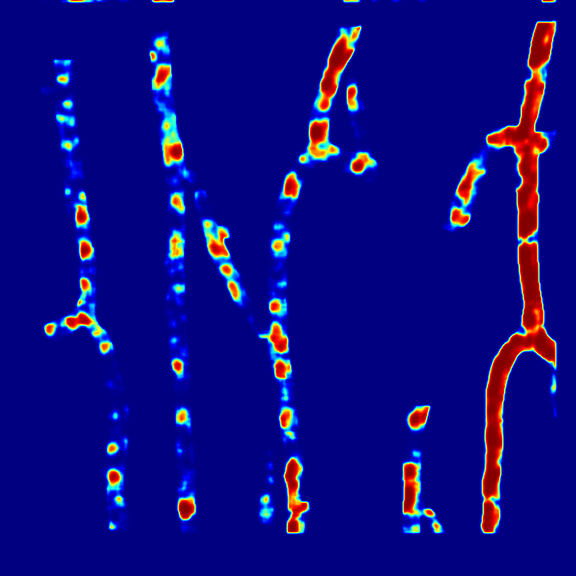

In [46]:
def probability_map_cmap(probability_map, sigma):
    from PIL import Image
    from skimage.filters import gaussian
    probability_map = probability_map
    probability_map = gaussian(probability_map, sigma)
    probability_map = np.uint8(probability_map * 255)
    probability_map = cv2.applyColorMap(probability_map, cv2.COLORMAP_JET)
    probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
    probability_map = Image.fromarray(probability_map)
    return probability_map

frame_indices = list(session_classifiers[0].probability_maps)

probability_map_cmap(session_classifiers[0].probability_maps[frame_indices[0]], 1)

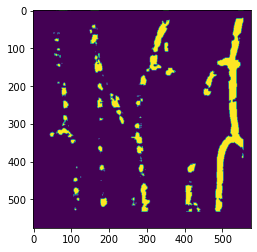

In [56]:
from skimage.filters import threshold_otsu

prob_map = session_classifiers[0].probability_maps[frame_indices[0]]
threshold = threshold_otsu(prob_map)

binary_image = prob_map.copy()
binary_image[prob_map > threshold] = 1
binary_image[prob_map <= threshold] = 0
binary_image = np.bool8(binary_image)

# plt.imshow(binary_image)
binary_image.shape

binary_image * 255
plt.imshow(binary_image)

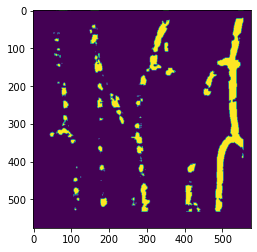

In [70]:
from PIL import Image



In [8]:
all_dices = []
all_false_discovery_rates = []
all_true_positive_rates = []

all_sigmas = []
all_hs = []
all_ts = []

uid_to_sigmas = {}
uid_to_hs = {}
uid_to_ts = {}

uid_to_s = {}
uid_to_h = {}
uid_to_t = {}

for vsc in session_classifiers:
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    
    print(vsc.session.uid)
    uid_to_sigmas[vsc.session.uid] =  sigmas
    uid_to_hs[vsc.session.uid] = hs
    uid_to_ts[vsc.session.uid] = ts
    
    uid_to_s[vsc.session.uid] = np.mean(sigmas)
    uid_to_h[vsc.session.uid] = np.mean(hs)
    uid_to_t[vsc.session.uid] = np.mean(ts)
    
    all_sigmas.extend(sigmas)
    all_hs.extend(hs)
    all_ts.extend(ts)
    
    all_dices.extend(dices)
    all_false_discovery_rates.extend(false_discovery_rates)
    all_true_positive_rates.extend(true_positive_rates)

416
429
980


In [9]:
import collections
data = collections.OrderedDict(
    dice=np.mean(all_dices),
    true_positive_rate=np.mean(all_true_positive_rates), 
    false_discovery_rate=np.mean(all_false_discovery_rates)
)
print(pd.DataFrame(data, columns=list(data.keys()), index=[0]).to_string(index=False))

     dice  true_positive_rate  false_discovery_rate
 0.753276            0.749195              0.233785


### Load session classifiers

In [10]:
loaded_session_classifiers = []

# Load session_classifiers
for vs in validation_video_sessions:
    vsc = SessionClassifier.from_file(
        os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=False)
    loaded_session_classifiers.append(vsc)

In [11]:
all_dices = []
all_false_discovery_rates = []
all_true_positive_rates = []
all_true_positive_dists = []

for vsc in loaded_session_classifiers:
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_dists = [evaluation.true_positive_dists.mean() for evaluation in vsc.result_evaluations.values()]
    
    all_dices.extend(dices)
    all_false_discovery_rates.extend(false_discovery_rates)
    all_true_positive_rates.extend(true_positive_rates)
    all_true_positive_dists.extend(true_positive_dists)

In [12]:
print('Model validation performance\n',  recorded_models_props['valid_classification_results'])
print()

Model validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0           0.832286  0.832042     0.832656     0.831915



In [13]:
test_sensitivity = np.mean(sensitivities)
test_specificity = np.mean(specificities)
test_balanced_accuracy = np.mean(balanced_accuracies)
test_accuracy = np.mean(accuracies)

performance_data = {
    'Balanced accuracy': test_balanced_accuracy,
    'Accuracy': test_accuracy,
    'Sensitivity': test_sensitivity,
    'Specificity': test_specificity
}

df = pd.DataFrame(performance_data, columns=list(performance_data.keys()), index=[0])
print('Model test performance')
print(df.to_string(index=False))

Model test performance
 Balanced accuracy  Accuracy  Sensitivity  Specificity
          0.767598  0.723239     0.817931     0.717265


In [14]:
import collections
data = collections.OrderedDict(
    dice=np.mean(all_dices),
    true_positive_rate=np.mean(all_true_positive_rates), 
    false_discovery_rate=np.mean(all_false_discovery_rates),
    mean_distance=np.mean(all_true_positive_dists)
)
print(pd.DataFrame(data, columns=list(data.keys()), index=[0]).to_string(index=False))

     dice  true_positive_rate  false_discovery_rate  mean_distance
 0.753276            0.749195              0.233785       4.654096


In [40]:
def probability_map_cmap(probability_map, sigma):
    from PIL import Image
    from skimage.filters import gaussian
    probability_map = probability_map
    probability_map = gaussian(probability_map, sigma)
    probability_map = np.uint8(probability_map * 255)
    probability_map = cv2.applyColorMap(probability_map, cv2.COLORMAP_JET)
    probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
    probability_map = Image.fromarray(probability_map)
    return probability_map

# Worst prob map

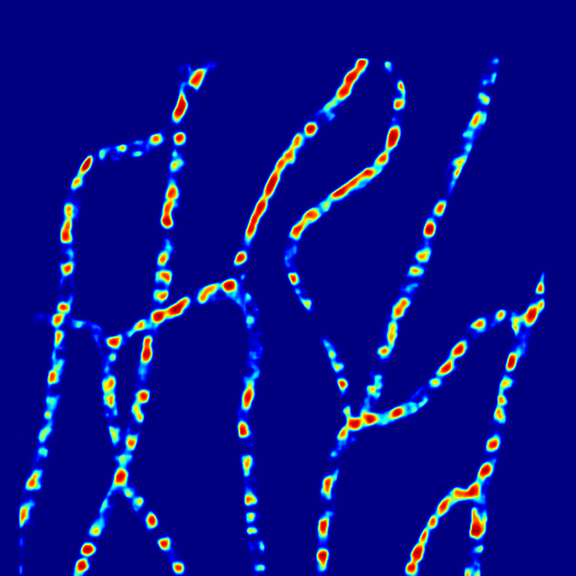

In [20]:
vsc_idx = 1
worse_dice_idx = np.argmin([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
worst_prob_map_frame_idx = list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[worse_dice_idx]

probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[worst_prob_map_frame_idx], 
                     loaded_session_classifiers[vsc_idx].result_evaluations[worst_prob_map_frame_idx].sigma)

# Best prob map

0.7914438502673797


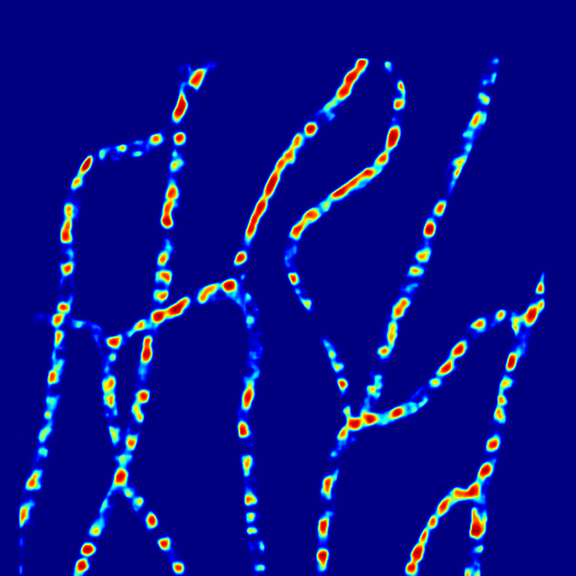

In [28]:
vsc_idx = 1
best_dice_idx = np.argmax([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
best_prob_map_frame_idx =list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[best_dice_idx]
print([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()][best_dice_idx])
prob_map = probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[worst_prob_map_frame_idx], 
                                loaded_session_classifiers[vsc_idx].result_evaluations[worst_prob_map_frame_idx].sigma)
prob_map.save('uid43_best_dice_probmap.png')
prob_map